In [50]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
import datetime


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [51]:
dataset = tfds.load("eurosat", split="train[25%:75%]")

In [52]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))

dataset = dataset.shuffle(len(dataset))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

## settings

In [53]:
IMAGE_SIZE = (64,64,3) 

LABELS = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]
BATCH_SIZE = 16
EPOCHS=20
TEST_SIZE = 0.18

### exploring the dataset

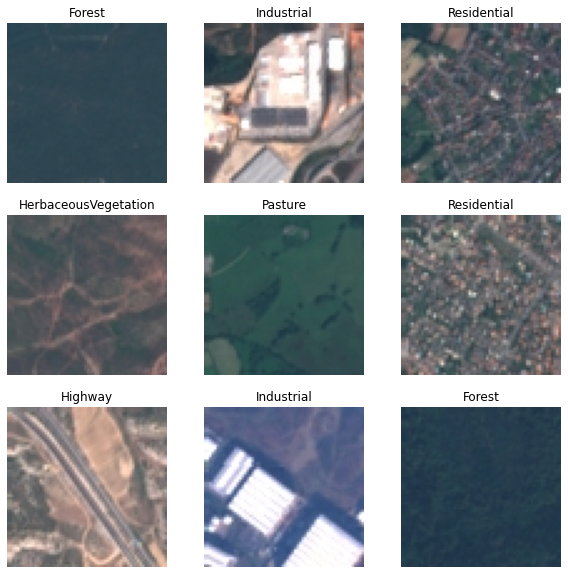

In [54]:
plt.figure(figsize=(10, 10))
for i,sample in enumerate(test_dataset.take(9)):
    image = sample["image"] 
    label = sample["label"]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(LABELS[int(label)])
    plt.axis("off")

### Tiny Resnet50

<ul>
    <li>We  perform  downsampling  directly  byconvolutional layers that have a stride of <strong>2</strong></li>
</ul>

In [16]:
def residual_block(inputs, filters, kernel_size, is_downsampled=False):
    """
        compute a complete residual block 
        Arguments: 
            inputs: an input tensor
            filters: a list of the number of filters for each conv layer 
            kernel_size: a list of kernel sizes for each conv layer
    """
    if len(filters) != len(kernel_size): 
        return None
    
    identity = inputs 
    x = inputs 
    for i in range(len(filters)): 
        if is_downsampled and i == 0: 
            x = tf.keras.layers.Conv2D(
                filters=filters[i], 
                kernel_size=kernel_size[i], 
                padding="same", 
                strides=2
            )(x)
        else: 
            x = tf.keras.layers.Conv2D(
                filters=filters[i], 
                kernel_size=kernel_size[i], 
                padding="same", 
                strides=1
            )(x)
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    if is_downsampled: 
        # we downsample the identity block by using 1x1 filters with a stride of 2
        identity = tf.keras.layers.Conv2D(filters=filters[-1], kernel_size=1, padding="same", strides=2)(identity)
    else: 
        identity = tf.keras.layers.Conv2D(filters=filters[-1], kernel_size=1, padding="same", strides=1)(identity)
    outputs = identity + x  
    outputs = tf.keras.activations.relu(outputs)
    
    return outputs


def tiny_resnet50(nb_classses, input_shape): 
    
    inputs = tf.keras.Input(shape=(64,64,3)) 
    
    first_conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(first_conv)
    
    # stacking residual blocks
    all_filters = [
        [28,28, 64], 
        [128,128,128], 
        [256,256,256]
    ]
    
    kernel_sizes = [1,3,1]
    
    for filters in all_filters: 
        for i in range(2): 
            if i == 0: 
                downsample = True
            else: 
                downsample = False
            
            x = residual_block(x,filters,kernel_sizes, is_downsampled=downsample)
            
    
    x = tf.keras.layers.AveragePooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nb_classses)(x)
    outputs = tf.keras.activations.sigmoid(x)
    
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model
    
    

In [70]:
resnet50 = tiny_resnet50(len(LABELS), IMAGE_SIZE)
print(IMAGE_SIZE)

(64, 64, 3)


In [18]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 28)     1820        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [55]:
def preprocess_data(sample):
    image = tf.cast(sample["image"], dtype=tf.float32)
    label = tf.one_hot(
        sample["label"], 
        depth=len(LABELS)
    )
    
    return (image, label)

### Training 

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tensorboard_callback, 
    tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True)
]

### Do not run if you've already trained the model

In [59]:
train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)

train_dataset = train_dataset.batch(BATCH_SIZE) 
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### Do not run if you've already trained the model

In [12]:
resnet50.compile(
    optimizer="sgd",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [13]:
resnet50.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_dataset,
)


Epoch 1/20
591/591 [==============================] - 22s 21ms/step - loss: 1.5684 - accuracy: 0.4293 - val_loss: 2.2345 - val_accuracy: 0.3062
Epoch 2/20
591/591 [==============================] - 11s 19ms/step - loss: 1.1119 - accuracy: 0.5981 - val_loss: 2.0050 - val_accuracy: 0.4237
Epoch 3/20
591/591 [==============================] - 11s 19ms/step - loss: 0.9872 - accuracy: 0.6414 - val_loss: 1.0927 - val_accuracy: 0.6242
Epoch 4/20
591/591 [==============================] - 11s 19ms/step - loss: 0.8734 - accuracy: 0.6832 - val_loss: 2.9250 - val_accuracy: 0.3600
Epoch 5/20
591/591 [==============================] - 11s 19ms/step - loss: 0.8272 - accuracy: 0.7068 - val_loss: 1.6948 - val_accuracy: 0.4237
Epoch 6/20
591/591 [==============================] - 11s 19ms/step - loss: 0.7629 - accuracy: 0.7270 - val_loss: 0.8230 - val_accuracy: 0.6973
Epoch 7/20
591/591 [==============================] - 11s 19ms/step - loss: 0.7101 - accuracy: 0.7443 - val_loss: 8.1779 - val_accuracy:

## Observations of the naïve resnet50 model

### The model is overfitting

<p>Possible solutions for this problem</p>

<ol>
    <li>More data</li>
    <li>Adding Data Augmentation </li>
    <li>Adding regularization (Lr decay, Dropout)</li>
    <li>Reduce complexity</li>
</ol>

In [11]:
%tensorboard --logdir logs/fit

### Let's add a data augmentation pipeline

In [56]:
def data_augmentation(): 
    
    inputs = tf.keras.Input(shape=IMAGE_SIZE)
    x = inputs
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(x)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.4)(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[x])


In [57]:
data_augm = data_augmentation()

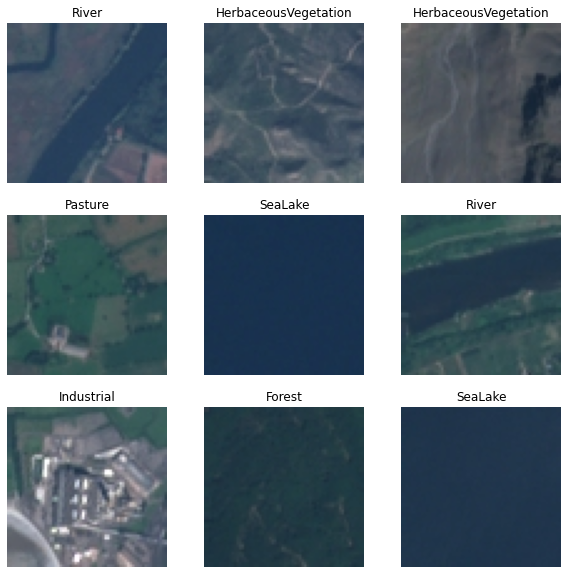

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): 
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(LABELS[np.argmax(labels[i])])
        plt.axis("off")

In [67]:
def resnet_augm(): 
    
    inputs = tf.keras.Input(shape=IMAGE_SIZE) 
    
    x = inputs 
    x_augm = data_augm(x)
    outputs = resnet50(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[outputs])
    

### Training the same model with data augmentation

In [71]:
resnet50 = resnet_augm()
resnet50.summary()

In [72]:
log_dir = "logs/fit/data_augm" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tensorboard_callback, 
    tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True)
]

In [73]:
resnet50.compile(
    optimizer="sgd",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

resnet50.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_dataset,
)



Epoch 1/20
591/591 [==============================] - 29s 21ms/step - loss: 1.7987 - accuracy: 0.3377 - val_loss: 3.3382 - val_accuracy: 0.2519
Epoch 2/20
591/591 [==============================] - 11s 19ms/step - loss: 1.3026 - accuracy: 0.5256 - val_loss: 1.7284 - val_accuracy: 0.4420
Epoch 3/20
591/591 [==============================] - 11s 19ms/step - loss: 1.1515 - accuracy: 0.5796 - val_loss: 3.7966 - val_accuracy: 0.2148
Epoch 4/20
591/591 [==============================] - 11s 19ms/step - loss: 1.0239 - accuracy: 0.6327 - val_loss: 1.5566 - val_accuracy: 0.4128
Epoch 5/20
591/591 [==============================] - 11s 19ms/step - loss: 0.9265 - accuracy: 0.6672 - val_loss: 2.7138 - val_accuracy: 0.4217
Epoch 6/20
591/591 [==============================] - 11s 19ms/step - loss: 0.8553 - accuracy: 0.6970 - val_loss: 3.7069 - val_accuracy: 0.2000
Epoch 7/20
591/591 [==============================] - 11s 19ms/step - loss: 0.8266 - accuracy: 0.7018 - val_loss: 0.8491 - val_accuracy:

### Adding data augmentation didn't fix the overfitting 

### Trying different learning rates 

In [74]:
learning_rates = [0.001, 0.0001, 0.0005]
resnet50 = resnet_augm()
for lr in learning_rates: 
    log_dir = f"logs/fit/data_augm_{lr}" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks = [
        tensorboard_callback, 
        tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True)
    ]
    
    resnet50.compile(
        optimizer=tf.keras.optimizers.SGD(lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    resnet50.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=val_dataset,
    )




Epoch 1/20
591/591 [==============================] - 13s 20ms/step - loss: 0.3351 - accuracy: 0.8879 - val_loss: 0.2501 - val_accuracy: 0.9225
Epoch 2/20
591/591 [==============================] - 11s 19ms/step - loss: 0.2978 - accuracy: 0.9026 - val_loss: 0.2076 - val_accuracy: 0.9398
Epoch 3/20
591/591 [==============================] - 11s 19ms/step - loss: 0.2866 - accuracy: 0.9032 - val_loss: 0.1942 - val_accuracy: 0.9368
Epoch 4/20
591/591 [==============================] - 11s 18ms/step - loss: 0.2755 - accuracy: 0.9084 - val_loss: 0.2089 - val_accuracy: 0.9348
Epoch 5/20
591/591 [==============================] - 11s 19ms/step - loss: 0.2786 - accuracy: 0.9078 - val_loss: 0.1611 - val_accuracy: 0.9580
Epoch 6/20
591/591 [==============================] - 11s 19ms/step - loss: 0.2580 - accuracy: 0.9135 - val_loss: 0.2347 - val_accuracy: 0.9289
Epoch 7/20
591/591 [==============================] - 11s 19ms/step - loss: 0.2528 - accuracy: 0.9202 - val_loss: 0.3184 - val_accuracy:

Epoch 18/20
591/591 [==============================] - 11s 18ms/step - loss: 0.1291 - accuracy: 0.9606 - val_loss: 0.0527 - val_accuracy: 0.9886
Epoch 19/20
591/591 [==============================] - 11s 18ms/step - loss: 0.1327 - accuracy: 0.9611 - val_loss: 0.2238 - val_accuracy: 0.9180
Epoch 20/20
591/591 [==============================] - 11s 18ms/step - loss: 0.1281 - accuracy: 0.9615 - val_loss: 0.0790 - val_accuracy: 0.9788
